<a href="https://colab.research.google.com/github/intel-analytics/BigDL/blob/branch-2.0/python/nano/notebooks/hpo/seq_and_func.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

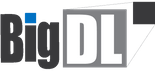

# Introduction
In this notebook we demonstrates how to use Nano HPO to tune the hyperparameters in tensorflow training. The model is built using either tensorflow keras sequential API or functional API.


# Step0: Prepare Environment
You can install the latest pre-release version with nano support using `pip install --pre --upgrade bigdl-nano`.

In [1]:
# Install latest pre-release version of bigdl-nano
!pip install --pre --upgrade bigdl-nano
# Install other dependecies
!pip install ConfigSpace
!pip install optuna
exit() # restart the runtime to refresh installed pkg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.1 MB/s 
     |████████████████████████████████| 1.0 MB 47.7 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 81 kB 9.6 MB/s 
     |████████████████████████████████| 209 kB 42.0 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 112 kB 50.6 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 146 kB 56.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=ea21be2adeacc0f58c760474377051883c5be0e2d26910a7b54252c725b3e29f
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


After installing bigdl-nano, you can run the following command to setup a few environment variables.

In [3]:
!source bigdl-nano-init

conda dir found: /usr/local/bin/..
OpenMP library found...
Setting OMP_NUM_THREADS...
Setting OMP_NUM_THREADS specified for pytorch...
Setting KMP_AFFINITY...
Setting KMP_BLOCKTIME...
Setting MALLOC_CONF...
Not in a conda env
+++++ Env Variables +++++
LD_PRELOAD=/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4
MALLOC_CONF=
OMP_NUM_THREADS=1
KMP_AFFINITY=granularity=fine,compact,1,0
KMP_BLOCKTIME=1
TF_ENABLE_ONEDNN_OPTS=1
ENABLE_TF_OPTS=1
NANO_TF_INTER_OP=1
+++++++++++++++++++++++++
Complete.


# Step1: Init Nano AutoML
We need to enable Nano HPO before we use it for tensorflow training.

In [4]:
import bigdl.nano.automl as automl
automl.hpo_config.enable_hpo_tf()

After that, we need to import nano and other dependencies

In [5]:
from bigdl.nano.automl.tf.keras import Sequential
import bigdl.nano.automl.hpo.space as space
from bigdl.nano.tf.keras.layers import Dense, Flatten, Conv2D
from bigdl.nano.tf.keras import Input
from bigdl.nano.automl.tf.keras import Model
from bigdl.nano.automl.hpo.backend import PrunerType

from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow import keras

# Step2: Prepare data
We use MNIST dataset for demonstration.

In [6]:
CLASSES = 10

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

img_x, img_y = x_train.shape[1], x_train.shape[2]
input_shape = (img_x, img_y, 1)
x_train = x_train.reshape(-1, img_x, img_y,1).astype("float32") / 255
x_test = x_test.reshape(-1, img_x, img_y,1).astype("float32") / 255

11501568/11490434 [==============================] - 0s 0us/step


# Step3: Set search space
We now create our model. 

Whenever you want to search a hyperparameter, you can simply replace it with a space and set your own searching space.

(Optional)By running the next block, you can build this model using tensorflow keras sequential API.


In [7]:
model = Sequential()
model.add(Conv2D(
    filters=space.Categorical(32, 64),
    kernel_size=space.Categorical(3, 5),
    strides=space.Categorical(1, 2),
    activation=space.Categorical("relu", "linear"),
    input_shape=input_shape))
model.add(Flatten())
model.add(Dense(CLASSES, activation="softmax"))

(Optional)Or you can build this model by functional API.

In [ ]:
inputs = Input(shape=(784,))
x = Dense(units=space.Categorical(8,16,prefix='dense_1'), activation="relu")(inputs)
x = Dense(units=space.Categorical(32,64,prefix='dense_2'), activation="relu")(x)
outputs = Dense(units=10)(x)
model = Model(inputs=inputs, outputs=outputs, name="mnist_model")
# Resize the dataset for sequential model
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

# Step4: Compile model
We now compile our model with loss function, optimizer and metrics.

In [8]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=RMSprop(learning_rate=0.001),
    metrics=["accuracy"]
)

# Step5: Run hyperparameter search
Run hyperparameter search by calling `model.search`. Set `n_trials` to the number of trails you want to run, and set the `target_metric` and `direction` so that HPO optimizes the `target_metric` in the specified `direction`. Each trial will use a different set of hyperparameters in the search space range. Use `n_parallels` to set the nubmer of parallel processes to run trials. After search completes, you can use `search_summary` to retrive the search results for analysis. For more details, refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html)

In [9]:
%%time
model.search(
    n_trials=16,
    target_metric='val_accuracy',
    direction="maximize",
    pruner=PrunerType.HyperBand,
    pruner_kwargs={'min_resource':1, 'max_resource':100, 'reduction_factor':3},
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.2,
    verbose=False,
    n_parallels=8
)

[I 2022-06-06 13:25:30,107] A new study created in memory with name: no-name-733cb8cd-a519-4b81-931f-9dd2a9ec807d


Starting a new tuning


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,


Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
375/375 - 110s - loss: 0.3827 - accuracy: 0.8949 - val_loss: 0.2424 - val_accuracy: 0.9313 - 110s/epoch - 293ms/step
Epoch 2/5
375/375 - 110s - loss: 0.4245 - accuracy: 0.8873 - val_loss: 0.2573 - val_accuracy: 0.9300 - 110s/epoch - 294ms/step
Epoch 2/5
375/375 - 110s - loss: 0.4117 - accuracy: 0.8832 - val_loss: 0.2976 - val_accuracy: 0.9172 - 110s/epoch - 295ms/step
Epoch 2/5
375/375 - 114s - loss: 0.3840 - accuracy: 0.8863 - val_loss: 0.3025 - val_accuracy: 0.9130 - 114s/epoch - 303ms/step
Epoch 2/5
375/375 - 114s - loss: 0.3816 - accuracy: 0.8894 - val_loss: 0.2978 - val_accuracy: 0.9183 - 114s/epoch - 304ms/step
Epoch 2/5
375/375 - 119s - loss: 0.2529 - accuracy: 0.9262 - val_loss: 0.1149 - val_accuracy: 0.9704 - 119s/epoch - 318ms/step
Epoch 2/5
375/375 - 119s - loss: 0.2437 - accuracy: 0.9294 - val_loss: 0.1057 - val_accuracy: 0.9703 - 119s/epoch - 318ms/step
375/375 - 119s - loss: 0.2962 - accuracy:

[I 2022-06-06 13:29:13,715] Trial 6 pruned. Trial was pruned at epoch 1.


375/375 - 106s - loss: 0.1076 - accuracy: 0.9696 - val_loss: 0.0903 - val_accuracy: 0.9765 - 106s/epoch - 282ms/step
Epoch 3/5
375/375 - 108s - loss: 0.0855 - accuracy: 0.9745 - val_loss: 0.0813 - val_accuracy: 0.9783 - 108s/epoch - 287ms/step
Epoch 3/5
375/375 - 111s - loss: 0.0890 - accuracy: 0.9743 - val_loss: 0.0849 - val_accuracy: 0.9769 - 111s/epoch - 297ms/step
Epoch 3/5
Epoch 1/5
375/375 - 86s - loss: 0.2979 - accuracy: 0.9147 - val_loss: 0.2774 - val_accuracy: 0.9232 - 86s/epoch - 229ms/step
Epoch 4/5
375/375 - 88s - loss: 0.1260 - accuracy: 0.9654 - val_loss: 0.1106 - val_accuracy: 0.9703 - 88s/epoch - 235ms/step
Epoch 4/5
375/375 - 87s - loss: 0.1720 - accuracy: 0.9517 - val_loss: 0.1411 - val_accuracy: 0.9643 - 87s/epoch - 232ms/step
Epoch 4/5
375/375 - 88s - loss: 0.2897 - accuracy: 0.9187 - val_loss: 0.2822 - val_accuracy: 0.9215 - 88s/epoch - 235ms/step
Epoch 4/5
375/375 - 93s - loss: 0.0728 - accuracy: 0.9795 - val_loss: 0.0799 - val_accuracy: 0.9792 - 93s/epoch - 247ms

[I 2022-06-06 13:32:34,148] Trial 7 pruned. Trial was pruned at epoch 3.


375/375 - 99s - loss: 0.0484 - accuracy: 0.9861 - val_loss: 0.0728 - val_accuracy: 0.9796 - 99s/epoch - 263ms/step
Epoch 5/5
375/375 - 79s - loss: 0.3115 - accuracy: 0.9121 - val_loss: 0.2891 - val_accuracy: 0.9193 - 79s/epoch - 210ms/step
Epoch 3/5
Epoch 1/5
375/375 - 74s - loss: 0.2848 - accuracy: 0.9204 - val_loss: 0.2780 - val_accuracy: 0.9205 - 74s/epoch - 197ms/step
375/375 - 74s - loss: 0.1013 - accuracy: 0.9719 - val_loss: 0.1040 - val_accuracy: 0.9733 - 74s/epoch - 199ms/step


[I 2022-06-06 13:33:12,108] Trial 3 finished with value: 0.9733333587646484 and parameters: {'activation▁choice': 0, 'filters▁choice': 0, 'kernel_size▁choice': 0, 'strides▁choice': 1}. Best is trial 3 with value: 0.9733333587646484.


Epoch 1/5
375/375 - 78s - loss: 0.0778 - accuracy: 0.9777 - val_loss: 0.0898 - val_accuracy: 0.9748 - 78s/epoch - 207ms/step
375/375 - 79s - loss: 0.2743 - accuracy: 0.9229 - val_loss: 0.2770 - val_accuracy: 0.9227 - 79s/epoch - 211ms/step
375/375 - 71s - loss: 0.0488 - accuracy: 0.9864 - val_loss: 0.0746 - val_accuracy: 0.9796 - 71s/epoch - 190ms/step
375/375 - 61s - loss: 0.2994 - accuracy: 0.9153 - val_loss: 0.2932 - val_accuracy: 0.9215 - 61s/epoch - 163ms/step
Epoch 4/5
375/375 - 76s - loss: 0.0397 - accuracy: 0.9884 - val_loss: 0.0754 - val_accuracy: 0.9802 - 76s/epoch - 201ms/step
375/375 - 55s - loss: 0.3011 - accuracy: 0.9140 - val_loss: 0.1349 - val_accuracy: 0.9638 - 55s/epoch - 147ms/step
Epoch 2/5


[I 2022-06-06 13:33:57,947] Trial 5 finished with value: 0.9801666736602783 and parameters: {'activation▁choice': 0, 'filters▁choice': 1, 'kernel_size▁choice': 0, 'strides▁choice': 0}. Best is trial 5 with value: 0.9801666736602783.
[I 2022-06-06 13:33:58,003] Trial 2 finished with value: 0.9802500009536743 and parameters: {'activation▁choice': 0, 'filters▁choice': 0, 'kernel_size▁choice': 0, 'strides▁choice': 0}. Best is trial 2 with value: 0.9802500009536743.
[I 2022-06-06 13:33:58,285] Trial 4 finished with value: 0.9231666922569275 and parameters: {'activation▁choice': 1, 'filters▁choice': 0, 'kernel_size▁choice': 1, 'strides▁choice': 1}. Best is trial 2 with value: 0.9802500009536743.
[I 2022-06-06 13:33:58,295] Trial 0 finished with value: 0.9748333096504211 and parameters: {'activation▁choice': 0, 'filters▁choice': 1, 'kernel_size▁choice': 0, 'strides▁choice': 1}. Best is trial 2 with value: 0.9802500009536743.
[I 2022-06-06 13:33:58,307] Trial 1 finished with value: 0.927166640

Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
375/375 - 55s - loss: 0.3063 - accuracy: 0.9114 - val_loss: 0.1457 - val_accuracy: 0.9597 - 55s/epoch - 146ms/step
Epoch 2/5
375/375 - 56s - loss: 0.2918 - accuracy: 0.9190 - val_loss: 0.2889 - val_accuracy: 0.9195 - 56s/epoch - 151ms/step
Epoch 5/5


[I 2022-06-06 13:35:13,410] Trial 9 pruned. Trial was pruned at epoch 1.


375/375 - 100s - loss: 0.3921 - accuracy: 0.8871 - val_loss: 0.3096 - val_accuracy: 0.9127 - 100s/epoch - 266ms/step
Epoch 2/5


[I 2022-06-06 13:35:42,168] Trial 10 pruned. Trial was pruned at epoch 1.


375/375 - 104s - loss: 0.2348 - accuracy: 0.9312 - val_loss: 0.0975 - val_accuracy: 0.9732 - 104s/epoch - 276ms/step
Epoch 2/5
375/375 - 105s - loss: 0.3847 - accuracy: 0.8888 - val_loss: 0.3074 - val_accuracy: 0.9107 - 105s/epoch - 279ms/step
Epoch 2/5
375/375 - 106s - loss: 0.2504 - accuracy: 0.9278 - val_loss: 0.1096 - val_accuracy: 0.9695 - 106s/epoch - 283ms/step
Epoch 2/5
375/375 - 80s - loss: 0.2857 - accuracy: 0.9198 - val_loss: 0.2823 - val_accuracy: 0.9237 - 80s/epoch - 213ms/step


[I 2022-06-06 13:36:21,783] Trial 8 finished with value: 0.9237499833106995 and parameters: {'activation▁choice': 1, 'filters▁choice': 1, 'kernel_size▁choice': 1, 'strides▁choice': 1}. Best is trial 2 with value: 0.9802500009536743.
[I 2022-06-06 13:36:41,529] Trial 13 pruned. Trial was pruned at epoch 1.


375/375 - 168s - loss: 0.3940 - accuracy: 0.8889 - val_loss: 0.2931 - val_accuracy: 0.9173 - 168s/epoch - 447ms/step
Epoch 2/5
375/375 - 69s - loss: 0.0786 - accuracy: 0.9771 - val_loss: 0.0694 - val_accuracy: 0.9808 - 69s/epoch - 184ms/step
Epoch 3/5


[I 2022-06-06 13:36:55,461] Trial 11 pruned. Trial was pruned at epoch 1.


375/375 - 72s - loss: 0.0882 - accuracy: 0.9745 - val_loss: 0.0813 - val_accuracy: 0.9772 - 72s/epoch - 193ms/step
Epoch 3/5
375/375 - 36s - loss: 0.3044 - accuracy: 0.9144 - val_loss: 0.2915 - val_accuracy: 0.9193 - 36s/epoch - 96ms/step
Epoch 3/5
375/375 - 45s - loss: 0.0554 - accuracy: 0.9839 - val_loss: 0.0729 - val_accuracy: 0.9791 - 45s/epoch - 119ms/step
Epoch 4/5
375/375 - 49s - loss: 0.0618 - accuracy: 0.9824 - val_loss: 0.0747 - val_accuracy: 0.9791 - 49s/epoch - 132ms/step
Epoch 4/5
375/375 - 33s - loss: 0.2904 - accuracy: 0.9175 - val_loss: 0.2762 - val_accuracy: 0.9239 - 33s/epoch - 89ms/step
Epoch 4/5
375/375 - 45s - loss: 0.0444 - accuracy: 0.9865 - val_loss: 0.0646 - val_accuracy: 0.9832 - 45s/epoch - 120ms/step
Epoch 5/5


[I 2022-06-06 13:38:29,660] Trial 15 pruned. Trial was pruned at epoch 3.
[I 2022-06-06 13:38:35,338] Trial 14 pruned. Trial was pruned at epoch 3.


375/375 - 25s - loss: 0.0368 - accuracy: 0.9893 - val_loss: 0.0623 - val_accuracy: 0.9826 - 25s/epoch - 66ms/step


[I 2022-06-06 13:39:25,403] Trial 12 finished with value: 0.9831666946411133 and parameters: {'activation▁choice': 0, 'filters▁choice': 0, 'kernel_size▁choice': 1, 'strides▁choice': 0}. Best is trial 12 with value: 0.9831666946411133.


CPU times: user 24min 50s, sys: 45 s, total: 25min 35s
Wall time: 13min 55s


In [10]:
print(model.search_summary())

Number of finished trials: 16
Best trial:
  Value: 0.9831666946411133
  Params: 
    activation▁choice: 0
    filters▁choice: 0
    kernel_size▁choice: 1
    strides▁choice: 0


# Step6: (Optional) Resume training from memory
You can resume the previous search when a search completes by setting `resume=True`. Refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html) for more details.

In [11]:
%%time
model.search(
    n_trials=4,
    target_metric='val_accuracy',
    direction="maximize",
    pruner=PrunerType.HyperBand,
    pruner_kwargs={'min_resource':1, 'max_resource':100, 'reduction_factor':3},
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.2,
    verbose=False,
    resume = True,
    n_parallels=4
)

/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,


Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
375/375 - 56s - loss: 0.4178 - accuracy: 0.8851 - val_loss: 0.2880 - val_accuracy: 0.9171 - 56s/epoch - 150ms/step
Epoch 2/5
375/375 - 63s - loss: 0.2251 - accuracy: 0.9355 - val_loss: 0.0967 - val_accuracy: 0.9738 - 63s/epoch - 169ms/step
Epoch 2/5
375/375 - 63s - loss: 0.2485 - accuracy: 0.9256 - val_loss: 0.1057 - val_accuracy: 0.9700 - 63s/epoch - 169ms/step
Epoch 2/5
375/375 - 72s - loss: 0.1948 - accuracy: 0.9418 - val_loss: 0.0827 - val_accuracy: 0.9751 - 72s/epoch - 191ms/step
Epoch 2/5
375/375 - 45s - loss: 0.3024 - accuracy: 0.9138 - val_loss: 0.2812 - val_accuracy: 0.9224 - 45s/epoch - 120ms/step
Epoch 3/5
375/375 - 59s - loss: 0.0843 - accuracy: 0.9759 - val_loss: 0.0773 - val_accuracy: 0.9784 - 59s/epoch - 157ms/step
Epoch 3/5
375/375 - 60s - loss: 0.0814 - accuracy: 0.9761 - val_loss: 0.0749 - val_accuracy: 0.9790 - 60s/epoch - 160ms/step
Epoch 3/5
375/375 - 70s - loss: 0.0662 - accuracy: 0.9805 - val_loss: 0.0690 - val_accuracy: 0.

[I 2022-06-06 13:43:26,695] Trial 19 pruned. Trial was pruned at epoch 3.


375/375 - 45s - loss: 0.2786 - accuracy: 0.9223 - val_loss: 0.2707 - val_accuracy: 0.9258 - 45s/epoch - 119ms/step
375/375 - 58s - loss: 0.0461 - accuracy: 0.9869 - val_loss: 0.0603 - val_accuracy: 0.9823 - 58s/epoch - 155ms/step
Epoch 5/5
375/375 - 54s - loss: 0.0363 - accuracy: 0.9890 - val_loss: 0.0542 - val_accuracy: 0.9843 - 54s/epoch - 144ms/step
Epoch 5/5


[I 2022-06-06 13:43:50,352] Trial 18 finished with value: 0.9258333444595337 and parameters: {'activation▁choice': 1, 'filters▁choice': 0, 'kernel_size▁choice': 0, 'strides▁choice': 1}. Best is trial 12 with value: 0.9831666946411133.


375/375 - 36s - loss: 0.0382 - accuracy: 0.9888 - val_loss: 0.0578 - val_accuracy: 0.9835 - 36s/epoch - 96ms/step
375/375 - 32s - loss: 0.0290 - accuracy: 0.9916 - val_loss: 0.0600 - val_accuracy: 0.9837 - 32s/epoch - 84ms/step


[I 2022-06-06 13:44:50,222] Trial 16 finished with value: 0.9835000038146973 and parameters: {'activation▁choice': 0, 'filters▁choice': 0, 'kernel_size▁choice': 1, 'strides▁choice': 0}. Best is trial 16 with value: 0.9835000038146973.
[I 2022-06-06 13:44:50,353] Trial 17 finished with value: 0.984250009059906 and parameters: {'activation▁choice': 0, 'filters▁choice': 1, 'kernel_size▁choice': 1, 'strides▁choice': 0}. Best is trial 17 with value: 0.984250009059906.


CPU times: user 9min 14s, sys: 17.1 s, total: 9min 31s
Wall time: 5min 24s


In [12]:
print(model.search_summary())

Number of finished trials: 20
Best trial:
  Value: 0.984250009059906
  Params: 
    activation▁choice: 0
    filters▁choice: 1
    kernel_size▁choice: 1
    strides▁choice: 0


# Step 7: fit with the best hyperparameters
After search, `model.fit` will autotmatically use the best hyperparmeters found in search to fit the model.

In [13]:
history = model.fit(x_train, y_train,
                    batch_size=128, epochs=5, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/5
375/375 [==============================] - 29s 76ms/step - loss: 0.1996 - accuracy: 0.9406 - val_loss: 0.0867 - val_accuracy: 0.9744
Epoch 2/5
375/375 [==============================] - 28s 75ms/step - loss: 0.0663 - accuracy: 0.9806 - val_loss: 0.0654 - val_accuracy: 0.9818
Epoch 3/5
375/375 [==============================] - 29s 78ms/step - loss: 0.0473 - accuracy: 0.9864 - val_loss: 0.0583 - val_accuracy: 0.9826
Epoch 4/5
375/375 [==============================] - 28s 75ms/step - loss: 0.0356 - accuracy: 0.9892 - val_loss: 0.0547 - val_accuracy: 0.9841
Epoch 5/5
375/375 [==============================] - 28s 75ms/step - loss: 0.0287 - accuracy: 0.9915 - val_loss: 0.0538 - val_accuracy: 0.9852
313/313 - 2s - loss: 0.0419 - accuracy: 0.9877 - 2s/epoch - 6ms/step
Test loss: 0.04187000170350075
Test accuracy: 0.9876999855041504


# Step 8: HPO Result Analysis and Visualization
Check out the summary of the model. The model has already been built with the best hyperparameters found by nano hpo.

In [14]:
print(model.summary())
study = model.search_summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 10)                368650    
                                                                 
Total params: 370,314
Trainable params: 370,314
Non-trainable params: 0
_________________________________________________________________
None
Number of finished trials: 20
Best trial:
  Value: 0.984250009059906
  Params: 
    activation▁choice: 0
    filters▁choice: 1
    kernel_size▁choice: 1
    strides▁choice: 0


In [15]:
print(study.trials_dataframe(attrs=("number", "value", "params", "state")))

    number     value  params_activation▁choice  params_filters▁choice  \
0        0  0.974833                         0                      1   
1        1  0.927167                         1                      0   
2        2  0.980250                         0                      0   
3        3  0.973333                         0                      0   
4        4  0.923167                         1                      0   
5        5  0.980167                         0                      1   
6        6  0.913833                         1                      1   
7        7  0.976833                         0                      1   
8        8  0.923750                         1                      1   
9        9  0.972833                         0                      1   
10      10  0.975000                         0                      0   
11      11  0.919250                         1                      1   
12      12  0.983167                         0     

In [16]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

In [17]:
from optuna.visualization import plot_parallel_coordinate
plot_parallel_coordinate(study)

In [18]:
from optuna.visualization import plot_intermediate_values
plot_intermediate_values(study)

In [19]:
from optuna.visualization import plot_contour
plot_contour(study)

In [20]:
from optuna.visualization import plot_param_importances
plot_param_importances(study)

In [21]:
plot_param_importances(study, target=lambda t: t.duration.total_seconds(), target_name="duration")